In [1]:
import pandas as pd

# Load both datasets
main_df = pd.read_excel('Main.xlsx')
pollution_df = pd.read_csv('Pollution.csv')

# Display basic info and head of each dataset
main_info = main_df.info()
pollution_info = pollution_df.info()

main_head = main_df.head()
pollution_head = pollution_df.head()

main_info, pollution_info, main_head, pollution_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2604 entries, 0 to 2603
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2604 non-null   int64  
 1   January    2548 non-null   float64
 2   February   2343 non-null   object 
 3   March      2563 non-null   object 
 4   April      2441 non-null   object 
 5   May        2532 non-null   object 
 6   June       2447 non-null   object 
 7   July       2547 non-null   object 
 8   August     2539 non-null   object 
 9   September  2471 non-null   object 
 10  October    2552 non-null   object 
 11  November   2481 non-null   object 
 12  December   2570 non-null   object 
 13  Location   2604 non-null   object 
 14  Year       2604 non-null   int64  
dtypes: float64(1), int64(2), object(12)
memory usage: 305.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3255 entries, 0 to 3254
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype

(None,
 None,
    Date  January February March April May June July August September October  \
 0     1    237.0       74    34   101  44   71   36     24        32      36   
 1     2    253.0      135    46   110  33   55   22     25        43      23   
 2     3    249.0      139    71   112  24   32   36     26        34      24   
 3     4    153.0      102    56    73  22   43   39     26        34      30   
 4     5    111.0      104    58    71  25   34   43     22        35      22   
 
   November December  Location  Year  
 0       32      112  Amravati  2021  
 1       31      130  Amravati  2021  
 2       39       93  Amravati  2021  
 3       31       85  Amravati  2021  
 4       69       63  Amravati  2021  ,
   country  state       city                          station  \
 0   India  Assam    Nalbari       Bata Chowk, Nalbari - PCBA   
 1   India  Assam    Nalbari       Bata Chowk, Nalbari - PCBA   
 2   India  Assam    Silchar          Tarapur, Silchar - PCBA   
 3 

In [2]:
# First, convert all monthly columns in `main_df` to numeric
months = ['January', 'February', 'March', 'April', 'May', 'June', 
          'July', 'August', 'September', 'October', 'November', 'December']

# Convert object columns to numeric and coerce errors to NaN
for month in months:
    main_df[month] = pd.to_numeric(main_df[month], errors='coerce')

# Check missing values after conversion
missing_values = main_df[months].isnull().sum()

# Drop rows with too many missing monthly values (e.g., > 6 months missing)
main_df_cleaned = main_df.dropna(thresh=len(months) - 6)

# Fill remaining missing values with monthly mean
main_df_cleaned[months] = main_df_cleaned[months].apply(lambda x: x.fillna(x.mean()), axis=0)

# Create 'avg_env_impact' feature from monthly averages
main_df_cleaned['avg_env_impact'] = main_df_cleaned[months].mean(axis=1)

# Show updated data
main_df_cleaned.head(), missing_values

(   Date  January  February  March  April   May  June  July  August  September  \
 0     1    237.0      74.0   34.0  101.0  44.0  71.0  36.0    24.0       32.0   
 1     2    253.0     135.0   46.0  110.0  33.0  55.0  22.0    25.0       43.0   
 2     3    249.0     139.0   71.0  112.0  24.0  32.0  36.0    26.0       34.0   
 3     4    153.0     102.0   56.0   73.0  22.0  43.0  39.0    26.0       34.0   
 4     5    111.0     104.0   58.0   71.0  25.0  34.0  43.0    22.0       35.0   
 
    October  November  December  Location  Year  avg_env_impact  
 0     36.0      32.0     112.0  Amravati  2021       69.416667  
 1     23.0      31.0     130.0  Amravati  2021       75.500000  
 2     24.0      39.0      93.0  Amravati  2021       73.250000  
 3     30.0      31.0      85.0  Amravati  2021       57.833333  
 4     22.0      69.0      63.0  Amravati  2021       54.750000  ,
 January       56
 February     277
 March         51
 April        179
 May           98
 June         170
 

In [3]:
# First, define mapping of heritage sites to nearby cities (assumed)
heritage_sites = {
    'Taj Mahal': 'Agra',
    'Ajanta Caves': 'Aurangabad',
    'Konark Temple': 'Konark'
}

# Filter pollution data for relevant cities
pollution_filtered = pollution_df[pollution_df['city'].isin(heritage_sites.values())]

# Group by city and pollutant to compute average pollution
pollution_aggregated = (
    pollution_filtered.groupby(['city', 'pollutant_id'])['pollutant_avg']
    .mean()
    .reset_index()
    .pivot(index='city', columns='pollutant_id', values='pollutant_avg')
    .reset_index()
)

# Rename columns for clarity
pollution_aggregated.columns.name = None
pollution_aggregated.rename(columns={'city': 'Location'}, inplace=True)

# Match site names in main data to city names
main_df_sites = main_df_cleaned.copy()
main_df_sites['Location'] = main_df_sites['Location'].replace({v: k for k, v in heritage_sites.items()})

# Map cities to site names in pollution data
pollution_aggregated['Location'] = pollution_aggregated['Location'].replace({v: k for k, v in heritage_sites.items()})

# Merge main data with pollution data on Location
combined_df = pd.merge(main_df_sites, pollution_aggregated, on='Location', how='left')

combined_df.head()

,Date,January,February,March,April,May,June,July,August,September,...,Location,Year,avg_env_impact,CO,NH3,NO2,OZONE,PM10,PM2.5,SO2
0,1,237.0,74.0,34.0,101.0,44.0,71.0,36.0,24.0,32.0,...,Amravati,2021,69.416667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,253.0,135.0,46.0,110.0,33.0,55.0,22.0,25.0,43.0,...,Amravati,2021,75.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,249.0,139.0,71.0,112.0,24.0,32.0,36.0,26.0,34.0,...,Amravati,2021,73.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,153.0,102.0,56.0,73.0,22.0,43.0,39.0,26.0,34.0,...,Amravati,2021,57.833333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,111.0,104.0,58.0,71.0,25.0,34.0,43.0,22.0,35.0,...,Amravati,2021,54.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


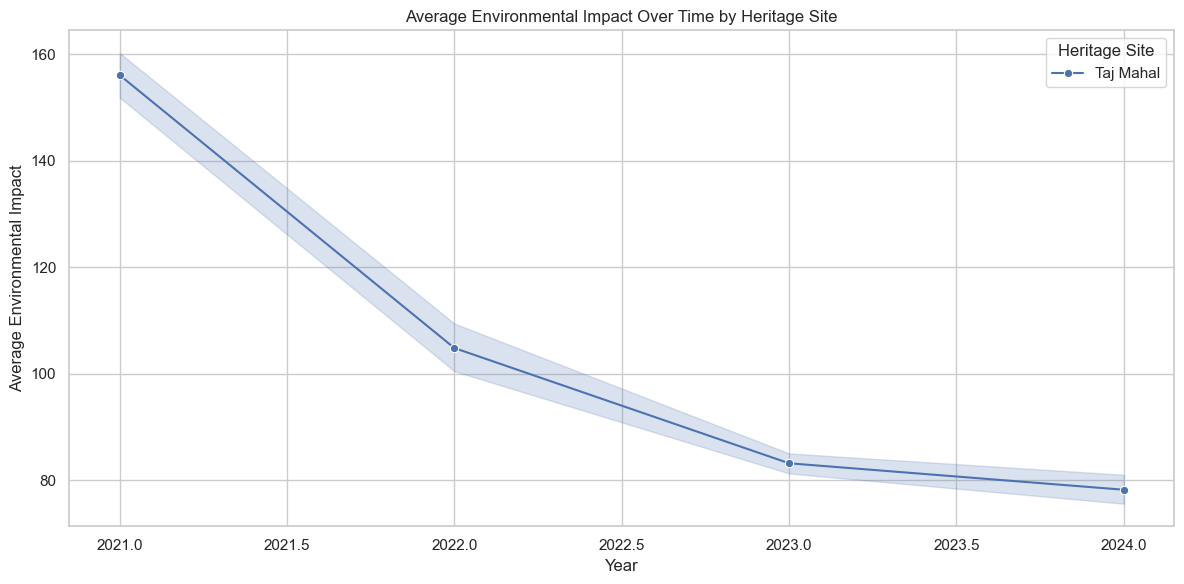

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter dataset for only heritage sites
heritage_only_df = combined_df[combined_df['Location'].isin(heritage_sites.keys())]

# Set plot style
sns.set(style="whitegrid")

# Plot 1: Average environmental impact over time by site
plt.figure(figsize=(12, 6))
sns.lineplot(data=heritage_only_df, x='Year', y='avg_env_impact', hue='Location', marker='o')
plt.title('Average Environmental Impact Over Time by Heritage Site')
plt.ylabel('Average Environmental Impact')
plt.xlabel('Year')
plt.legend(title='Heritage Site')
plt.tight_layout()
plt.show()


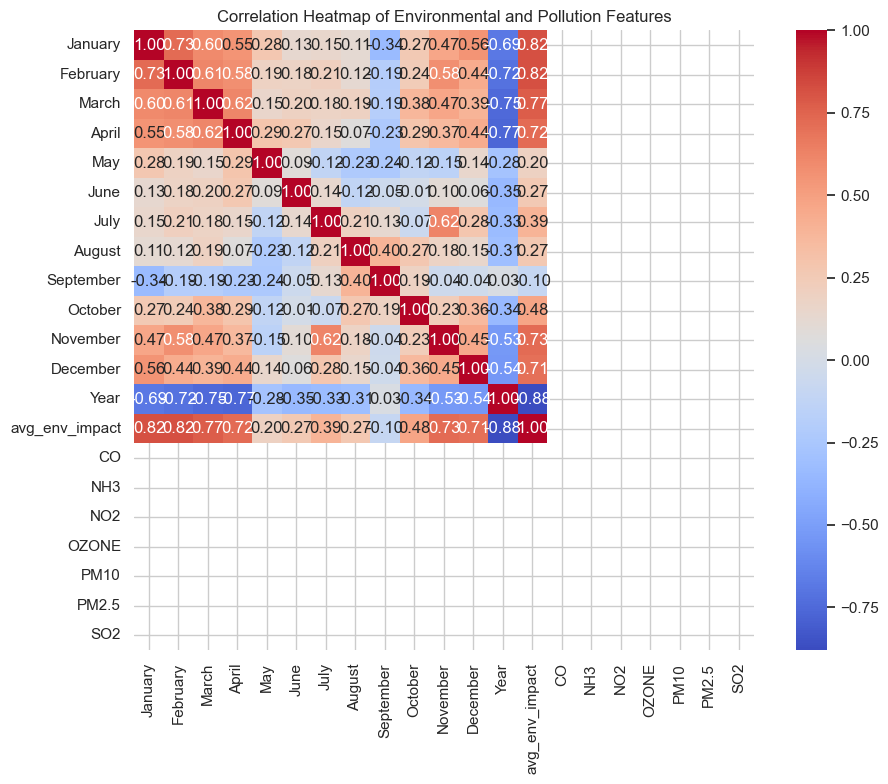

In [5]:

# Plot 2: Correlation heatmap of features
plt.figure(figsize=(10, 8))
corr = heritage_only_df.drop(columns=['Date']).select_dtypes(include='number').corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Heatmap of Environmental and Pollution Features')
plt.tight_layout()
plt.show()



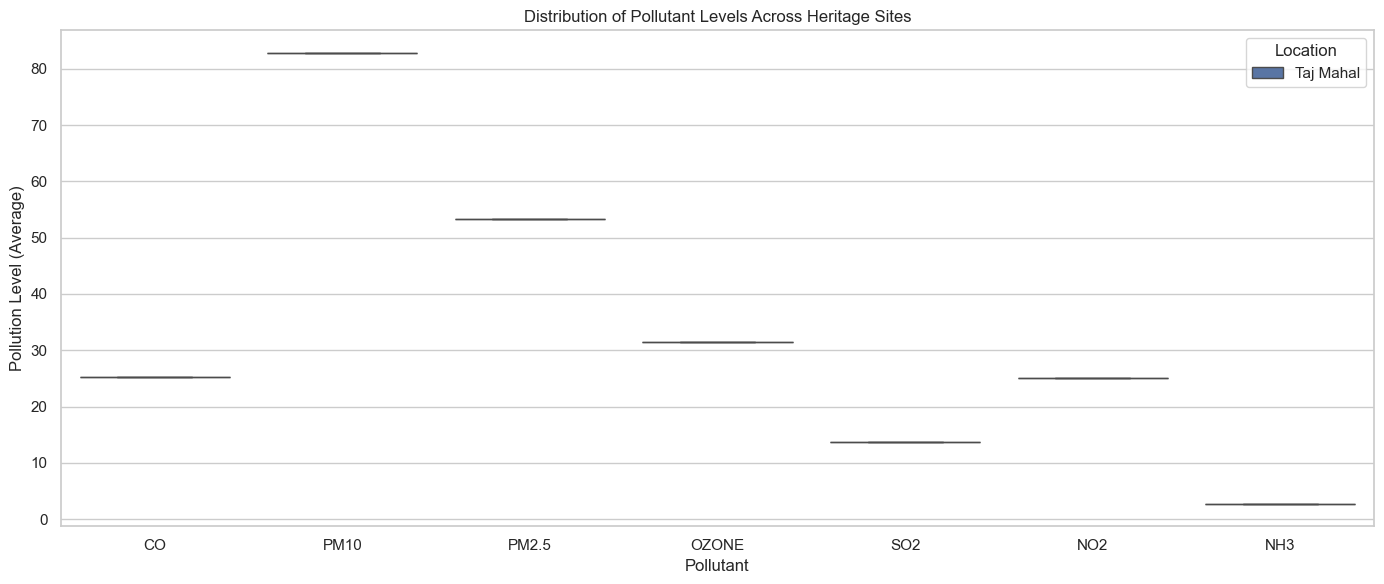

In [6]:
# Plot 3: Boxplot of pollutant levels across heritage sites
pollutants = ['CO', 'PM10', 'PM2.5', 'OZONE', 'SO2', 'NO2', 'NH3']
melted_pollutants = heritage_only_df.melt(id_vars='Location', value_vars=pollutants, var_name='Pollutant', value_name='Level')

plt.figure(figsize=(14, 6))
sns.boxplot(data=melted_pollutants, x='Pollutant', y='Level', hue='Location')
plt.title('Distribution of Pollutant Levels Across Heritage Sites')
plt.ylabel('Pollution Level (Average)')
plt.tight_layout()
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, classification_report
import numpy as np

# Filter for heritage sites only
heritage_df = combined_df[combined_df['Location'].isin(heritage_sites.keys())].copy()

# Drop rows with any remaining NaN values
heritage_df.dropna(inplace=True)

# --------------------------
# REGRESSION MODEL
# --------------------------

# Define regression target and features
regression_target = 'avg_env_impact'
regression_features = ['CO', 'PM10', 'PM2.5', 'OZONE', 'SO2', 'NO2', 'NH3']

X_reg = heritage_df[regression_features]
y_reg = heritage_df[regression_target]

# Split and scale
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

# Train regression model
reg_model = LinearRegression()
reg_model.fit(X_train_reg_scaled, y_train_reg)

# Predict and evaluate
y_pred_reg = reg_model.predict(X_test_reg_scaled)
reg_mse = mean_squared_error(y_test_reg, y_pred_reg)
reg_r2 = r2_score(y_test_reg, y_pred_reg)

# --------------------------
# CLASSIFICATION MODEL
# --------------------------

# Define degradation risk category (Low, Medium, High)
def categorize_risk(value):
    if value < 60:
        return 'Low'
    elif 60 <= value < 80:
        return 'Medium'
    else:
        return 'High'

heritage_df['degradation_risk'] = heritage_df['avg_env_impact'].apply(categorize_risk)

X_clf = heritage_df[regression_features]
y_clf = heritage_df['degradation_risk']

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

# Train classifier
clf_model = RandomForestClassifier(random_state=42)
clf_model.fit(X_train_clf_scaled, y_train_clf)

# Predict and evaluate
y_pred_clf = clf_model.predict(X_test_clf_scaled)
clf_report = classification_report(y_test_clf, y_pred_clf)

reg_mse
reg_r2 
clf_report

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


'              precision    recall  f1-score   support\n\n        High       0.68      1.00      0.81        17\n      Medium       0.00      0.00      0.00         8\n\n    accuracy                           0.68        25\n   macro avg       0.34      0.50      0.40        25\nweighted avg       0.46      0.68      0.55        25\n'